# Plasma Cells: Generating Embeddings
### Sid Gurajala
### 10/27/2022

In [5]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(tidyr)
library(viridis)
library(stringr)
library(pheatmap)
library(presto)
library(pals)
library(harmony)
library(singlecellmethods)
library(lisi)
library(RSpectra)
source("/data/srlab/ik936/Foxxy/utils/utils.R")
source("/data/srlab/anathan/scripts/scseq_utils.R")
library(parallel)




# weighted PCA is in immunogenomics/singlecellmethods, function weighted_pca
weighted_pca <- function(X, weights, genes_use=NULL, npc=20, do_corr=TRUE, scale_thresh=10) {
    if (!identical(length(weights), ncol(X))) {
        stop('Columns in X must match length of weights')
    }
    
#     y <- factor(y)
#     weights <- as.numeric((1 / prop.table(table(y)))[y]) / nlevels(y)
    if (any(is.na(weights))) {
        idx_keep <- which(is.na(weights))
#         y <- y[idx_keep]
        weights <- weights[idx_keep]
        X <- X[, idx_keep]
    }
    if (is.null(genes_use)) {
        genes_use <- row.names(X)
    } else if (length(genes_use) < nrow(X)) {
        if (any(!genes_use %in% row.names(X))) {
            stop('genes_use not in rownames of X')
        }
        X <- X[genes_use, ]
    }
    
    ## weighted z-scores
#     mu <- X %>% apply(1, function(x) {SDMTools:::wt.mean(x, weights)})
#     sig <- X %>% apply(1, function(x) {SDMTools:::wt.sd(x, weights)})
    mu <- singlecellmethods::rowMeans(X, weights = weights)
    sig <- singlecellmethods::rowSDs(X, weights = weights)
    
    # Added 12/9/19: save weighted scaling means and std devs
    vargenes_means_sds <- tibble(
        symbol = genes_use,
        mean = mu
    )
    vargenes_means_sds$stddev <- sig
    # finish added 12/9/19
    
    X <- scaleDataWithStats(X, mu, sig) 
    X <- X[which(is.na(rowSums(X)) == 0), ]
    if (do_corr) {
        X <- X %>% scale() %>% pmin(scale_thresh) %>% pmax(-scale_thresh)
    }
    
    ## weighted SVD
#     pres <- rsvd::rsvd(X %*% Matrix::Diagonal(x = sqrt(weights)), k = npc)
    pres <- RSpectra::svds(X %*% Matrix::Diagonal(x = sqrt(weights)), npc)
    V <- (Matrix::Diagonal(x = 1 / sqrt(weights)) %*% pres$v) %*% diag(pres$d)
    V <- as.matrix(V)
    colnames(V) <- paste0('PC', 1:npc)
    row.names(V) <- colnames(X)
    colnames(pres$u) <- paste0('PC', 1:npc)
    row.names(pres$u) <- row.names(X)
    return(list(loadings = pres$u, embeddings = V, vargenes = vargenes_means_sds))
}

# Cosine normalize values
cosine_normalize <- function(X, MARGIN = 1, do_safe = TRUE) {
    if (do_safe) {
        X <- sweep(X, MARGIN, apply(X, MARGIN, max), "/")
    }
    sweep(X, MARGIN, apply(X, MARGIN, function(x) sqrt(sum(x^2))), "/")
}
                           
                                                    
do_pca <- function(X, weights, genes_use=NULL, npc=10, do_corr=TRUE) {
    if (is.null(genes_use)) {
        genes_use <- row.names(X)
    }
    mu <- X[genes_use, ] %>% apply(1, function(x) {SDMTools:::wt.mean(x, weights)})
    sig <- X[genes_use, ] %>% apply(1, function(x) {SDMTools:::wt.sd(x, weights)})
    
    X <- X[genes_use, ] %>% scaleDataWithStats(mu, sig) 
    X <- X[which(is.na(rowSums(X)) == 0), ]
    if (do_corr) {
        X <- scale(X)
    }
    pres <- rsvd::rsvd(X, k = npc)
    V <- pres$v %*% diag(pres$d)
    V <- data.table(V)
    colnames(V) <- paste0('PC', 1:npc)
    return(V)    
}
                           
get_stats <- function(X, weights, genes_use=NULL) {
    if (is.null(genes_use)) {
        genes_use <- row.names(X)
    }
    mu <- X[genes_use, ] %>% apply(1, function(x) {SDMTools:::wt.mean(x, weights)})
    sig <- X[genes_use, ] %>% apply(1, function(x) {SDMTools:::wt.sd(x, weights)})
    return(list(mu = mu, sig = sig))
}
                           
                           
vargenes_vst <- function(object, groups, topn, loess.span = 0.3) {
    clip.max <- sqrt(ncol(object))

    N <- ncol(object)
    if (missing(groups)) {
        groups <- rep('A', N)
    }
    
    res <- split(seq_len(N), groups) %>% lapply(function(idx) {
        object_group <- object[, idx]
        ## row means
        hvf.info <- data.frame(
          symbol = rownames(object_group), 
          mean = Matrix::rowMeans(object_group)
        )

        ## row vars
        hvf.info$variance <- rowVars(object_group, hvf.info$mean)

        ## initialize
        hvf.info$variance.expected <- 0
        hvf.info$variance.standardized <- 0

        not.const <- hvf.info$variance > 0

        ## loess curve fit 
        suppressWarnings({
            fit <- loess(formula = log10(variance) ~ log10(mean), 
                data = hvf.info[not.const, ], span = loess.span)            
        })

        ## extract fitted variance 
        hvf.info$variance.expected[not.const] <- 10^fit$fitted

        ## get row standard deviations after clipping
        hvf.info$variance.standardized <- rowVarsStd(
            object_group, 
            hvf.info$mean, 
            sqrt(hvf.info$variance.expected), 
            clip.max
        )

        hvf.info <- hvf.info %>% 
#             tibble::rownames_to_column('symbol') %>% 
            arrange(-variance.standardized) %>% 
            tibble::rowid_to_column('rank') %>% 
            transform(group = unique(groups[idx]))

        return(hvf.info)        
    })
    
    
    if (missing(topn)) {
        ## MODE 1: return table 
        res <- Reduce(rbind, res) %>% 
            dplyr::select(group, symbol, rank, everything())

        if (length(unique(res$group)) == 1) {
            res$group <- NULL
        }
    } else {
        ## MODE 2: return genes
        res <- lapply(res, function(x) head(x, topn)$symbol)
    }
    return(res)
}
                      
                      
plot_clusters3 <- function(cluster_ids, labels, pt_size = 20, label_size, umap_use = umap_post,
                           do_labels = FALSE,
                           do_points = TRUE, do_density = FALSE, alpha_pt = 1, min_cluster_size = 20) {
    cluster_table <- table(cluster_ids)
    plt_df <- umap_use %>% data.frame() %>% cbind(cluster = cluster_ids) %>% cbind(cluster_label = labels)
    factor_levels <- plt_df %>% select(cluster_label, cluster) %>% unique() %>% arrange(as.numeric(cluster)) %>% pull(cluster_label)
    plt <- plt_df %>%
        dplyr::sample_frac(1L) %>%
        ggplot(aes(hUMAP1, hUMAP2, col = factor(cluster_label, levels = factor_levels), fill = factor(cluster_label, factor_levels)))
    if (do_points)
        plt <- plt + geom_point(alpha = alpha_pt, size = 0.5) + theme_classic()
    if (do_density)
        plt <- plt + geom_density_2d()


    plt <- plt +
     #   theme_tufte() +
#         theme(axis.line = element_line()) +
        guides(color = guide_legend(override.aes = list(size = 6))) +
#         scale_color_manual(values = sample(unique(singler.colors))) +
#         scale_color_manual(values = palette_use) +
        labs(x = "UMAP 1", y = "UMAP 2") +
        theme(plot.title = element_text(hjust = .5))

    if (do_labels)
        plt <- plt + ggrepel::geom_label_repel(data = data.table(plt_df)[, .(hUMAP1 = mean(hUMAP1), hUMAP2 = mean(hUMAP2)), by = .(cluster)], label.size = NA,
                                aes(label = cluster), color = "white", size = label_size,  max.overlaps = 15) +
        guides(col = FALSE, fill = FALSE) +
#         scale_fill_manual(values = palette_use) +
        NULL
    return(plt)
}

plot_shuffled_features <- function(ab, umap, exprs, pct) {
    library(viridis)
    max.cutoff = quantile(exprs[ab,], pct)
    min.cutoff = quantile(exprs[ab,], 1-pct)
    
    tmp <- sapply(X = exprs[ab,], FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    tmp <- sapply(X = tmp, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
    umap_res_plot <- cbind(umap, tmp)
    return(ggplot(data = as.data.frame(umap_res_plot)[sample(nrow(umap_res_plot)),] , aes(x = V1, y = V2)) +
      geom_point(mapping = aes(color = tmp), size = 0.75) +
      scale_color_viridis(option = "inferno", end = pct) +
      theme_classic() +
      theme(plot.title = element_text(size = 15), legend.position = "none") +
      labs(title = ab, x = 'hUMAP1', y = 'hUMAP2', color = "Normalized Expression"))
}
                           fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 300)
}

Warning message:
“package ‘Seurat’ was built under R version 4.1.3”
Attaching SeuratObject

Attaching sp

Warning message:
“package ‘dplyr’ was built under R version 4.1.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.2”

Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack


Loading required package: viridisLite

Loading required package: Rcpp

Warning message:
“package ‘Rcpp’ was built under R version 4.1.3”
Loading required package: data.table

Warning message:
“package ‘data.table’ was built under R version 4.1.1”

Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching 

In [1]:
qcd_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/Plasma_subsetted_meta_10272022.rds')
qcd_norm_bp <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/BP_clusterQCd_norm_09232022.rds')
qcd_norm <- qcd_norm_bp[, qcd_meta$cell]

Loading required package: Matrix

Warning message:
“package ‘Matrix’ was built under R version 4.1.2”


ERROR: Error in qcd_norm_bp[, qcd_meta$cell]: object of type 'S4' is not subsettable


In [7]:
qcd_meta %>% filter(dataset == 'snRNAseq')

cell,sample,Annot.separate,dataset,uwotUMAP1,uwotUMAP2,Site,Type,processing.batch,nCount_RNA,nFeature_RNA,broad.type,qc_cluster,doublet_score,doublet_classification
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<int>,<dbl>,<chr>
AACTCCCAGGCAAAGA-1-AMPSLEkid_nuc_0137,AMPSLEkid_nuc_0137,T/NK,snRNAseq,7.126404,-8.265814,Rochester,LN,35,2631,1720,B/Plasma,4,0.09296348,no
ACCAGTATCAGAGCTT-1-AMPSLEkid_nuc_0137,AMPSLEkid_nuc_0137,T/NK,snRNAseq,7.116986,-8.269346,Rochester,LN,35,3823,2306,B/Plasma,9,0.09296348,no
CACAAACCAGGCGATA-1-AMPSLEkid_nuc_0137,AMPSLEkid_nuc_0137,T/NK,snRNAseq,7.116459,-8.268527,Rochester,LN,35,4255,2366,B/Plasma,3,0.09784250,no
CCACGGAAGAGCTATA-1-AMPSLEkid_nuc_0137,AMPSLEkid_nuc_0137,T/NK,snRNAseq,7.118615,-8.269880,Rochester,LN,35,2155,1429,B/Plasma,2,0.09296348,no
CGTTGGGCAAACCTAC-1-AMPSLEkid_nuc_0137,AMPSLEkid_nuc_0137,T/NK,snRNAseq,7.120323,-8.265527,Rochester,LN,35,3645,2144,B/Plasma,12,0.08842795,no
CTCGAGGTCCAAATGC-1-AMPSLEkid_nuc_0137,AMPSLEkid_nuc_0137,T/NK,snRNAseq,7.127234,-8.263995,Rochester,LN,35,1942,1391,B/Plasma,4,0.08842795,no
GAAATGAGTTACGACT-1-AMPSLEkid_nuc_0137,AMPSLEkid_nuc_0137,T/NK,snRNAseq,7.119880,-8.267965,Rochester,LN,35,4105,2359,B/Plasma,0,0.09296348,no
GATCGATCATGTCCTC-1-AMPSLEkid_nuc_0137,AMPSLEkid_nuc_0137,T/NK,snRNAseq,7.115509,-8.268792,Rochester,LN,35,6997,3099,B/Plasma,3,0.08842795,no
GCATGATTCGCGCCAA-1-AMPSLEkid_nuc_0137,AMPSLEkid_nuc_0137,T/NK,snRNAseq,7.119679,-8.266273,Rochester,LN,35,2632,1726,B/Plasma,2,0.09296348,no


## Normalization, Weighted PCA

In [3]:
genes_exclude <- c(grep("^MT-|^RPL|^RPS|MALAT1|MIR-", row.names(norm), value = TRUE), 
                   Seurat::cc.genes$s.genes, Seurat::cc.genes$g2m.genes) 

In [4]:
## Filtering for expressed genes
threshold_genes <- qcd_norm[rownames(qcd_norm[rowMeans(qcd_norm) >= .01, ]), ]

samples_25 <- qcd_meta %>% group_by(sample) %>% tally() %>% filter(n > 5) %>% pull(sample)

threshold_samples <- threshold_genes[, qcd_meta %>% filter(sample %in% samples_25) %>% pull(cell)]

## Variable gene selection — very inefficiently written, but essentially using VST to select most variable genes from samples with > 100 cells
var_genes_raw <- vargenes_vst(object = threshold_samples, groups = qcd_meta %>% filter(sample %in% samples_25) %>% pull(sample), topn = 500)

In [5]:
#Separate variable genes by Dataset
var_genes_raw_nuc <- vector()
var_genes_raw_sc <- vector()

for (i in 1:length(var_genes_raw)) {
    if (grepl('nuc', names(var_genes_raw)[i])) {
        var_genes_raw_nuc <- c(var_genes_raw_nuc, var_genes_raw[[i]])
    }
    else {
        var_genes_raw_sc <- c(var_genes_raw_sc, var_genes_raw[[i]])   
    }

}

var_genes_raw_nuc <- var_genes_raw_nuc %>% unique()
var_genes_raw_sc <- var_genes_raw_sc %>% unique() 
#Find intersection
var_genes <- intersect(var_genes_raw_nuc, var_genes_raw_sc)

In [91]:
## Scale Data
bp_scaled <- qcd_norm[var_genes[!var_genes %in% genes_exclude], ] %>% scaleData()

In [92]:
table(qcd_meta$dataset)
y <- factor(qcd_meta$dataset)
weights <- as.numeric((1 / prop.table(table(y)))[y]) / nlevels(y)
length(weights)
table(weights)


scRNAseq snRNAseq 
    4595      493 

[1] 5088

weights
0.553645266594124  5.16024340770791 
             4595               493 

In [93]:
bp_scaled <- as(bp_scaled, 'dgCMatrix')

In [94]:
weighted_pca_res <- weighted_pca(bp_scaled, weights, rownames(bp_scaled), 20, TRUE, 10)$embeddings

In [147]:
harmony_weighted2 <- HarmonyMatrix(weighted_pca_res, qcd_meta, 
                            c('sample', 'processing.batch', 'Site', 'dataset'), 
                            theta = c(0.5, 0, 0, 1.5),
                            do_pca = FALSE, 
                            epsilon.harmony = -Inf, 
                            epsilon.cluster = -Inf,
                            weights = weights, 
                            sigma = c(0.15),
                            max.iter.cluster = 20,
                            max.iter.harmony = 20, 
                            plot_convergence = TRUE, 
                            verbose = TRUE)

use_weights



[1] TRUE


use_weights

use_weights



[1] TRUE


use_weights

Harmony 1/20

Harmony 2/20

Harmony 3/20

Harmony 4/20

Harmony 5/20



ERROR: Error in harmonize(harmonyObj, max.iter.harmony, verbose): terminated by user


In [124]:
harmony_umap2 <- uwot::umap(harmony_weighted2, n_neighbors = 30L, metric = "euclidean", min_dist = .1)

In [125]:
weighted_umap <- uwot::umap(weighted_pca_res, n_neighbors = 30L, metric = "euclidean", min_dist = .1)

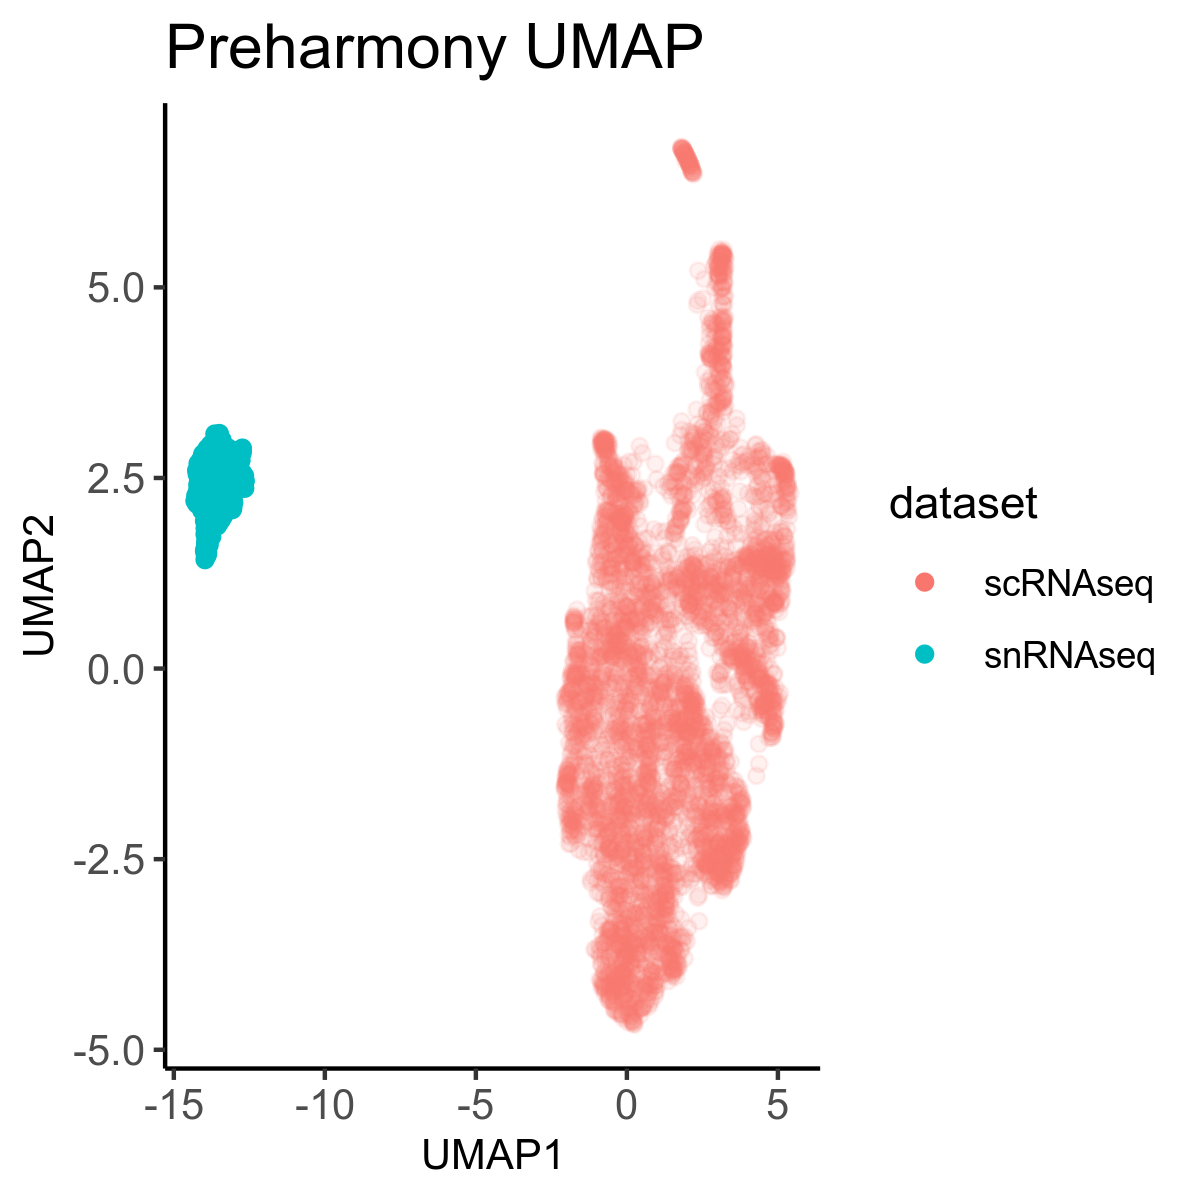

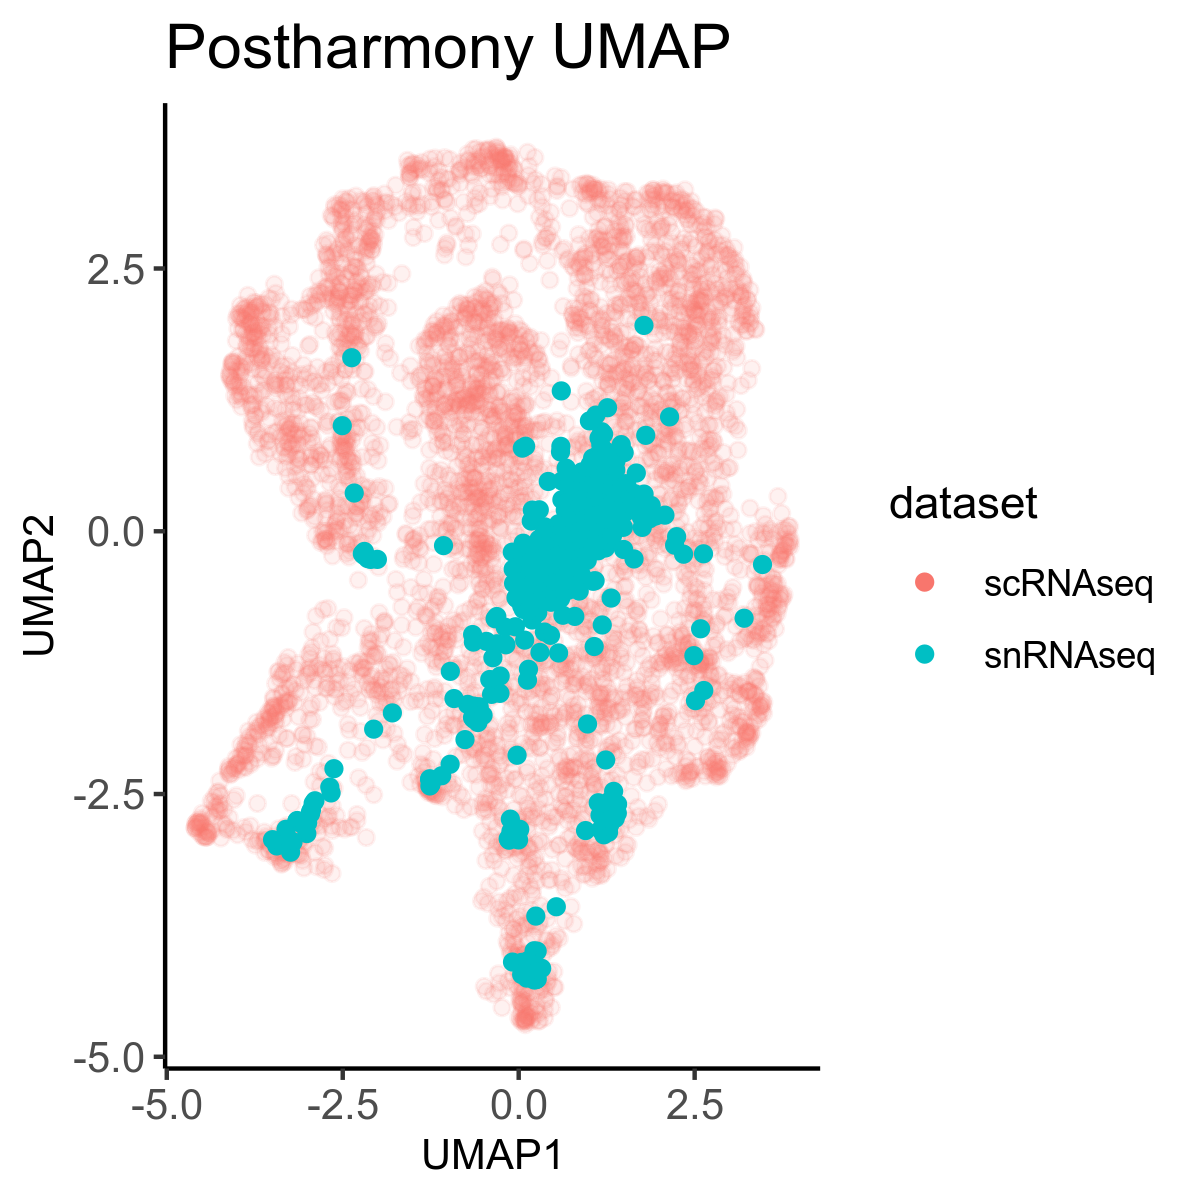

In [126]:
fig.size(4, 4)

df <- weighted_umap %>% data.frame() %>% mutate(dataset = qcd_meta$dataset)
ggplot(df, aes(x = X1, y = X2, color = dataset)) +
    geom_point(data = df %>% filter(dataset == 'scRNAseq'), alpha = 0.1, size = 1.5) +
    geom_point(data = df %>% filter(dataset == 'snRNAseq'), alpha = 2, size = 1.5) +
    theme_classic() + 
    theme(axis.text = element_text(size = 10), axis.title = element_text(size = 10), plot.title = element_text(size = 15)) +
    labs(title = 'Preharmony UMAP', x = 'UMAP1', y = 'UMAP2')

df <- harmony_umap2 %>% data.frame() %>% mutate(dataset = qcd_meta$dataset)
fig.size(4, 4)
ggplot(df, aes(x = X1, y = X2, color = dataset)) +
    geom_point(data = df %>% filter(dataset == 'scRNAseq'), alpha = 0.1, size = 1.5) +
    geom_point(data = df %>% filter(dataset == 'snRNAseq'), alpha = 2, size = 1.5) +
    theme_classic() + 
    theme(axis.text = element_text(size = 10), axis.title = element_text(size = 10), plot.title = element_text(size = 15)) +
    labs(title = 'Postharmony UMAP', x = 'UMAP1', y = 'UMAP2')

In [127]:
snn_ref <- BuildSNNSeurat(harmony_weighted2[,1:20], nn.eps = 0)


resolution_list <- c(0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0)
ids_ref <- Reduce(cbind, mclapply(resolution_list, function(res_use) {
    Seurat:::RunModularityClustering(SNN = snn_ref, modularity = 1,
        resolution = res_use, algorithm = 1, n.start = 20,
        n.iter = 20, random.seed = 100, print.output = FALSE,
        temp.file.location = NULL, edge.file.name = NULL)
}, mc.preschedule = FALSE, mc.cores = min(20, length(resolution_list)))) 

In [128]:
harmony_umap2 <- cbind(harmony_weighted2[, 1:20], harmony_umap2, ids_ref)
colnames(harmony_umap2) <- c(paste0('hPC', 1:20), 'hUMAP1', 'hUMAP2', 'hres0.2', 'hres0.4', 'hres0.6', 'hres0.8', 'hres1.0', 'hres1.2', 'hres1.4', 'hres1.6', 'hres1.8', 'hres2.0')

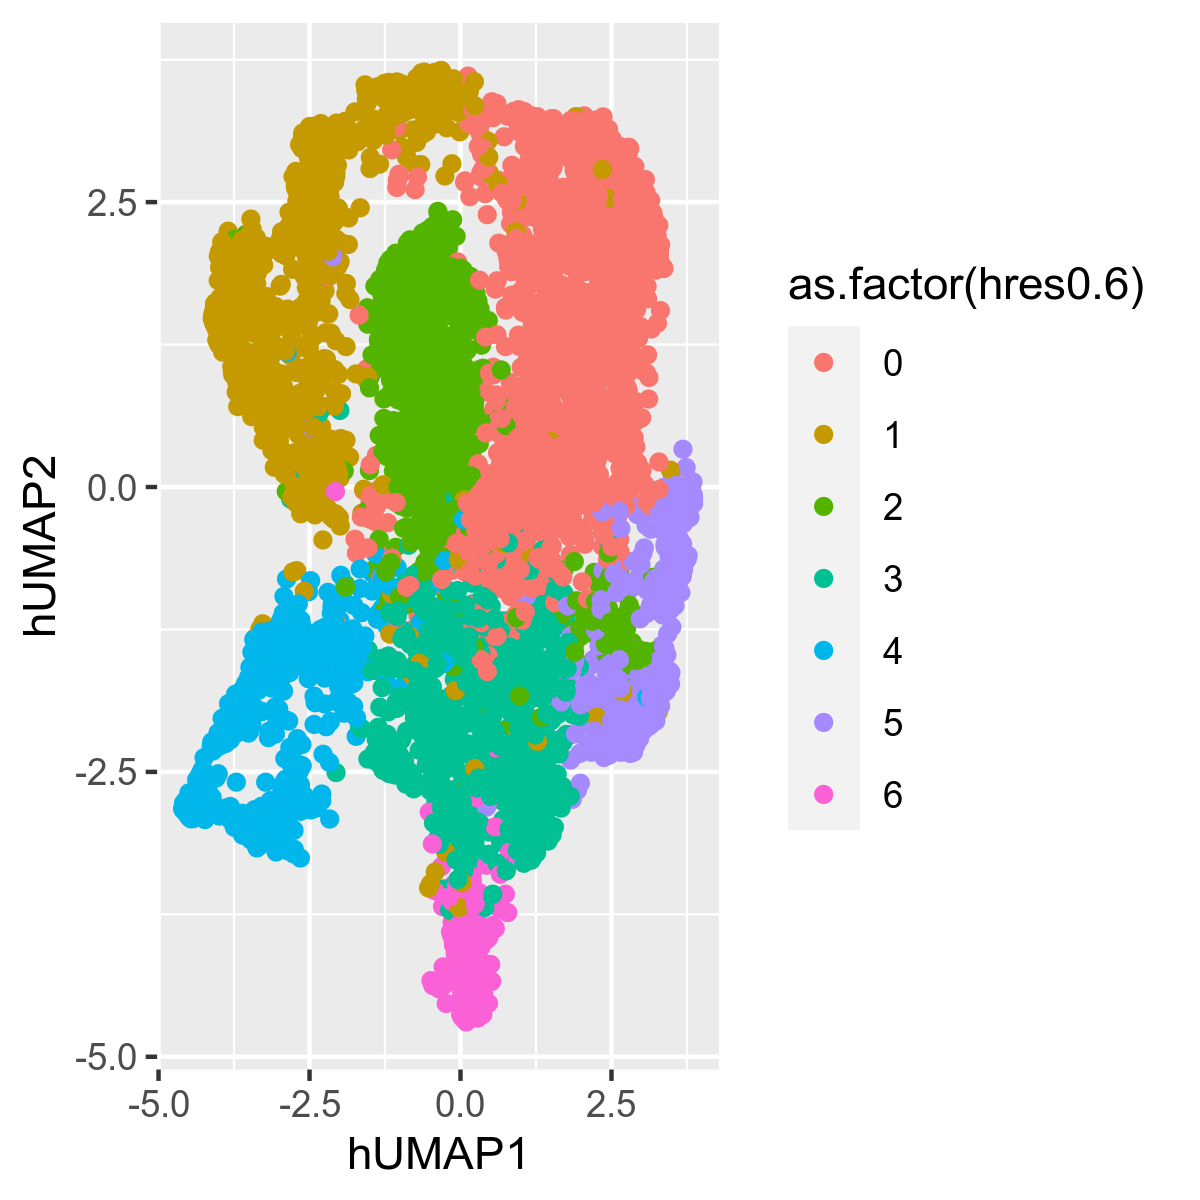

In [129]:
ggplot(data.frame(harmony_umap2), aes(x = hUMAP1, y = hUMAP2, color = as.factor(hres0.6))) + 
    geom_point()

In [134]:
qcd_meta <- cbind(qcd_meta, harmony_umap2)

## GENERATE EMBEDDINGS FOR CNA

In [136]:
library(readxl)
library(stringr)
clinical <- read_xlsx("/data/srlab2/jmears/jupyter/SLE_Phase2_Kidney_Analysis/cell-seq-output/FinalClinical/final_clinical_data_8-10-21_ResponderNA.xlsx")
clinical <- clinical %>% 
                        mutate(individual = str_split(Sample, '-')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2])

In [143]:
sn_cna_meta <- qcd_meta %>% 
                        filter(dataset == 'snRNAseq') %>% 
                        mutate(individual = str_split(sample, '_')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[3]) %>% left_join(clinical %>% 
                                                                                 select(-c('sample', 'Sample', 'Site', 'Type', 'processing.batch')), 
                                                                                 by = 'individual')
sc_cna_meta <- qcd_meta %>% 
                        filter(dataset == 'scRNAseq') %>% 
                        mutate(individual = str_split(sample, '_')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[3]) %>% left_join(clinical %>% 
                                                                                 select(-c('sample', 'Sample', 'Site', 'Type', 'processing.batch')), 
                                                                                 by = 'individual')

### SN CHRONICITY

In [138]:
meta <- sn_cna_meta %>% select(-c(colnames(sn_cna_meta[grep('hPC', colnames(sn_cna_meta))]), 
                          colnames(sn_cna_meta[grep('UMAP', colnames(sn_cna_meta))])))
harmony <- sn_cna_meta %>% select(colnames(sn_cna_meta)[grep('hPC', colnames(sn_cna_meta))])

umap <- sn_cna_meta %>% select(c(hUMAP1, hUMAP2))


ind <- meta$Chronicity == "NA"
sum(ind)
meta <- meta[!ind,]
umap <- umap[!ind,]
harmony <- harmony[!ind,]


meta$Type <- as.numeric(as.factor(meta$Type))
#meta$Site <- as.numeric(as.factor(meta$Site))
meta$Responder_Status <- as.numeric(as.factor(meta$Responder.Status))
meta$processing_batch <- as.numeric(as.factor(meta$processing.batch))
meta$Sex <- as.numeric(as.factor(meta$Sex))
#meta$Race <- as.numeric(as.factor(meta$Race))
meta$Ethnicity <- as.numeric(as.factor(meta$Ethnicity))
meta$ISN <- as.numeric(as.factor(meta$ISN))
meta$Chronicity <- as.numeric(as.factor(meta$Chronicity))
meta$Activity <- as.numeric(factor(meta$Activity, levels = c(0,1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,18)))

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna/plasma/sn_plasma_chronicity_meta.csv', row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna/plasma/sn_plasma_chronicity_harmony.csv', row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna/plasma/sn_plasma_chronicity_umap.csv', row.names = FALSE, quote = FALSE)

[1] 104

### SC CHRONICITY

In [144]:
meta <- sc_cna_meta %>% select(-c(colnames(sn_cna_meta[grep('hPC', colnames(sn_cna_meta))]), 
                          colnames(sn_cna_meta[grep('UMAP', colnames(sn_cna_meta))])))
harmony <- sc_cna_meta %>% select(colnames(sn_cna_meta)[grep('hPC', colnames(sn_cna_meta))])

umap <- sc_cna_meta %>% select(c(hUMAP1, hUMAP2))


ind <- meta$Chronicity == "NA"
sum(ind)
meta <- meta[!ind,]
umap <- umap[!ind,]
harmony <- harmony[!ind,]


meta$Type <- as.numeric(as.factor(meta$Type))
#meta$Site <- as.numeric(as.factor(meta$Site))
meta$Responder_Status <- as.numeric(as.factor(meta$Responder.Status))
meta$processing_batch <- as.numeric(as.factor(meta$processing.batch))
meta$Sex <- as.numeric(as.factor(meta$Sex))
#meta$Race <- as.numeric(as.factor(meta$Race))
meta$Ethnicity <- as.numeric(as.factor(meta$Ethnicity))
meta$ISN <- as.numeric(as.factor(meta$ISN))
meta$Chronicity <- as.numeric(as.factor(meta$Chronicity))
meta$Activity <- as.numeric(factor(meta$Activity, levels = c(0,1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,18)))

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna/plasma/sc_plasma_chronicity_meta.csv', row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna/plasma/sc_plasma_chronicity_harmony.csv', row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna/plasma/sc_plasma_chronicity_umap.csv', row.names = FALSE, quote = FALSE)

[1] 605